This is a notebook prepared for the LEAP workshop on July 24, 2025.

Author: Viviana Acquaviva (2025)

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

The data come from 

http://glass.umd.edu/KGClim/

and are based on the maps provided by Cui et al 2021 (https://essd.copernicus.org/articles/13/5087/2021/)

The goal of this exercise is to check whether we can reproduce the mapping of the Koppen-Geiger climate zones by using a random subset of a KG climate map as a training set. In short, we would like to use a Decision Tree to reproduce these behaviors (from Cui et al 2021).

![image](KGcriteria.png)

The input features we consider are the annual mean temperature (Tavg), the temperature of the warmest (Twm) and coldest month (Tcm), the annual precipitation (Ptot), and the precipitation in the wettest (Pwm) and driest month(Pdm).

The target is the Koppen-Geiger class, but we group them in 5 classes (A, B, C, D, E) instead of considering subclasses.




In [1]:
#Here we import different packages that we will need

import numpy as np
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #this will be used to split data into train and test sets
from sklearn.tree import DecisionTreeClassifier #this is our ML algorithm
from sklearn import metrics #this will give us access to evaluation metrics


In [2]:
#Here is a bunch of packages for visualization purposes only - this cell can be skipped if troublesome

from io import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz

In [3]:
#This is something that we have to do to open image files that are larger than the default limit in PIL

PIL.Image.MAX_IMAGE_PIXELS = 933120000


In [4]:
#The file we are going to use has 777600000 entries (data points); we will subsample to keep our numbers more manageable.

np.random.seed(10) #this fixes the random seed for reproducibility

indices = np.random.randint(0, 777600000, size=100000)

In [5]:
#create data frame with our input variables and target variable

df = pd.DataFrame(index=range(100000))

vars = ['Tavg','Twm', 'Tcm', 'Ptot', 'Pdm', 'Pwm','kc'] #These are our input variables + target

for var in vars:  
    file = '/Users/vivi/work/Climate/LEAPworkshop/1984_2013/'+var+'_1984_2013.tif'
    temp = PIL.Image.open(file)
    temp_array = np.array(temp)
    temp_sample = temp_array.reshape(-1, 1)[indices]
    df[var] = temp_sample


In [6]:
#We can look at the first few rows of the data frame to see what it looks like

df.head()

,Tavg,Twm,Tcm,Ptot,Pdm,Pwm,kc
0,-974,624,-2385,317,17,41,5.100000e+02
1,33,2133,-2498,600,6,133,4.220000e+02
2,-1538,623,-3404,129,3,26,5.100000e+02
3,2135,2412,1793,1281,11,259,3.210000e+02
4,-32768,-32768,-32768,-32768,-32768,-32768,-3.400000e+38


Eliminate rows with no KG label or missing values in other variables:

In [7]:
df_sel = df[np.logical_and(df.kc > 0, df.kc < 530)] #large negativ/positive values encoded missing values

for var in vars:
    df_sel = df_sel[df_sel[var] > -10000] #this removes the missing values, coded as -32768

In [8]:
df_sel.shape #This tells us how many rows and columns we have left after removing missing values


(28560, 7)

In [9]:
#We can now convert temps to Celsius (they were encoded as 100 times the Celsius value)

df_sel['Tavg'] = df_sel['Tavg']/100
df_sel['Twm'] = df_sel['Twm']/100
df_sel['Tcm'] = df_sel['Tcm']/100

In [10]:
df_sel.describe() #Let's look at the summary statistics of our data frame  

,Tavg,Twm,Tcm,Ptot,Pdm,Pwm,kc
count,28560.000000,28560.000000,28560.000000,28560.000000,28560.000000,28560.000000,28560.000000
mean,8.789361,20.367022,-2.918621,705.815756,19.807353,119.369328,321.806183
std,14.604689,9.216087,20.415027,682.671002,30.479907,113.141515,134.679672
min,-26.280000,-8.820000,-47.050000,0.000000,0.000000,0.000000,110.000000
25%,-3.100000,14.400000,-21.020000,262.000000,3.000000,47.000000,211.000000
50%,9.370000,21.440000,-2.240000,493.000000,10.000000,79.000000,331.000000
75%,23.080000,27.250000,16.360000,915.000000,24.000000,155.000000,433.000000
max,31.800000,39.380000,27.670000,8174.000000,437.000000,1721.000000,520.000000


In [11]:
#Re-define target values by aggregating Koppen classes into 5 groups

target = np.floor(df_sel.kc.values/100)

In [12]:
#Create main feature set

features = df_sel[vars].drop(columns=['kc'])

In [13]:
features.head()

,Tavg,Twm,Tcm,Ptot,Pdm,Pwm
0,-9.74,6.24,-23.85,317,17,41
1,0.33,21.33,-24.98,600,6,133
2,-15.38,6.23,-34.04,129,3,26
3,21.35,24.12,17.93,1281,11,259
6,-0.25,11.04,-10.39,560,29,73


We are now ready to define and fit the classification model:

In [14]:
model = DecisionTreeClassifier(random_state=10)

Divide data in train/test set


In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state=10)

Fit the model (build the tree)

In [16]:
model.fit(Xtrain, ytrain)

DecisionTreeClassifier(random_state=10)

Assess the accuracy of the model on the training and test set:

In [17]:
print('Test accuracy: ', np.round(metrics.accuracy_score(ytest, model.predict(Xtest)),3))
print('Train accuracy: ',metrics.accuracy_score(ytrain, model.predict(Xtrain)))

Test accuracy:  0.97
Train accuracy:  1.0


We can do some minimal optimization, using the parameter min_impurity_decrease to control the complexity of the tree. The goal is to maximize the test scores.

In [18]:
for min_impurity_decrease in np.arange(0,0.05,0.01):
    model = DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease, random_state=10)
    model.fit(Xtrain, ytrain)
    print('Train, test score', np.round(metrics.accuracy_score(ytest, model.predict(Xtest)),2), np.round(metrics.accuracy_score(ytrain, model.predict(Xtrain)),2))

Train, test score 0.97 1.0
Train, test score 0.94 0.94
Train, test score 0.93 0.93
Train, test score 0.93 0.93
Train, test score 0.93 0.93


The first model has the highest test scores, even if it shows a bit of overfitting (gap between train and test scores), so let's use it. Other models could also be used, they are robust and much simpler, at the cost of a slightly reduced accuracy.

In [19]:
model = DecisionTreeClassifier(min_impurity_decrease=0, random_state=10)
model.fit(Xtrain, ytrain)

DecisionTreeClassifier(min_impurity_decrease=0, random_state=10)

We can look at the built-in feature importances (although we can't 100% trust them in the case of correlated features like ours; also see what happens if you change the random seed!) to see if we can eliminate some unimportant ones.

In [20]:
model.feature_importances_, features.columns

(array([0.0293777 , 0.23289475, 0.41444242, 0.27168805, 0.03734706,
        0.01425002]),
 Index(['Tavg', 'Twm', 'Tcm', 'Ptot', 'Pdm', 'Pwm'], dtype='object'))

This shows that we can safely discard features Tavg, Pdm, and Pwm. However, this doesn't mean that the average temperature is unimportant! It just means that the information supplied by Twm and Tcm includes the information supplied by Tavg. The same reasoning applied to Pdm and Pwm - they are highly correlated with Ptot.

In [21]:
#Create a second feature set, removing the 'Tavg', 'Pdm', and 'Pwm' variables (and also the target variable 'kc')

features2 = df_sel[vars].drop(columns=['kc', 'Tavg', 'Pdm', 'Pwm'])

In [22]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(features2, target, test_size=0.2, random_state=10)

In [23]:
#Do some optimization, using the parameter min_impurity_decrease

for min_impurity_decrease in np.arange(0,0.05,0.01):
    model2 = DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease, random_state=10)
    model2.fit(Xtrain2, ytrain2)
    print('Train, test score', np.round(metrics.accuracy_score(ytest2, model2.predict(Xtest2)),2), np.round(metrics.accuracy_score(ytrain2, model2.predict(Xtrain2)),2))

Train, test score 0.96 1.0
Train, test score 0.94 0.94
Train, test score 0.93 0.93
Train, test score 0.93 0.93
Train, test score 0.93 0.93


We can still obtain the 96% test set accuracy with these three features, so we'll be using them for the remaining exercises.

In [24]:
model2 = DecisionTreeClassifier(min_impurity_decrease=0, random_state=10)
model2.fit(Xtrain2, ytrain2)

DecisionTreeClassifier(min_impurity_decrease=0, random_state=10)

In [25]:
# You can uncomment the code in this cell to plot the decision tree and check what happens 
# if you re-define model2 and use larger values of min_impurity_decrease, such as 0.01 or 0.05.

#from sklearn import tree

#plt.figure(figsize=(10,10))  # customize according to the size of your tree

#tree.plot_tree(model2,feature_names= list(features2.columns.values), class_names = ['1','2','3','4','5'])

#plt.show()

### This is how I built the small exercise for the workshop.

I started by only selecting classes 1, 2, and 5.

In [26]:
df_sel_tri = df_sel[np.logical_or(df_sel.kc < 250, df_sel.kc > 500)]

In [27]:
df_sel_tri.shape

(15628, 7)

In [28]:
features_tri = df_sel_tri[vars].drop(columns=['kc', 'Tavg', 'Pdm', 'Pwm'])

In [29]:
target_tri = np.floor(df_sel_tri.kc.values/100)

In [30]:
model_tri = DecisionTreeClassifier(random_state=10)

In [31]:
Xtrain_tri, Xtest_tri, ytrain_tri, ytest_tri = train_test_split(features_tri, target_tri, test_size=0.2, random_state=10)

In [32]:
model_tri.fit(Xtrain_tri, ytrain_tri)

DecisionTreeClassifier(random_state=10)

In [33]:
metrics.accuracy_score(ytest_tri, model_tri.predict(Xtest_tri))

0.9856046065259118

### Mini exercise with 20 examples

In [34]:

df_sel_tri_mini = df_sel_tri.sample(n=20, random_state=10)

df_sel_tri_mini.kc = np.floor(df_sel_tri_mini.kc/100).astype(int)

target_tri_mini = df_sel_tri_mini.kc.values



In [35]:
model_tri_mini = DecisionTreeClassifier(random_state=10)    

In [36]:
features_tri_mini = df_sel_tri_mini[vars].drop(columns=['kc', 'Tavg', 'Pdm', 'Pwm'])



In [37]:
features_tri_mini

,Twm,Tcm,Ptot
96185,35.55,21.88,944
26209,25.15,14.01,353
42694,4.43,-19.24,334
75583,-5.49,-34.30,534
22936,24.28,-8.93,421
9574,34.49,15.84,34
22605,23.80,19.07,1044
10514,32.27,13.61,147
57513,25.03,-10.76,216
37619,2.35,-30.90,137


In [38]:
#Some formatting stuff, to make the output more readable

for col in ['Twm', 'Tcm', 'Ptot']:
    features_tri_mini[col] = features_tri_mini[col].round(2)

features_tri_mini = features_tri_mini.rename(columns={'Twm': 'T (wettest month) (C)', 'Tcm': 'T (coldest month) (C)','ptot': 'Total Prec (mm)', 'kc': 'Koppen class'})

In [39]:
pd.concat([features_tri_mini, df_sel_tri_mini.kc], axis=1).head(20)

,T (wettest month) (C),T (coldest month) (C),Ptot,kc
96185,35.55,21.88,944,1
26209,25.15,14.01,353,2
42694,4.43,-19.24,334,5
75583,-5.49,-34.30,534,5
22936,24.28,-8.93,421,2
9574,34.49,15.84,34,2
22605,23.80,19.07,1044,1
10514,32.27,13.61,147,2
57513,25.03,-10.76,216,2
37619,2.35,-30.90,137,5


We choose the indices by hand here:

In [40]:
Xtrain_tri_mini = features_tri_mini.iloc[:15,:]

Xtest_tri_mini = features_tri_mini.iloc[15:,:]

ytrain_tri_mini = target_tri_mini[:15]

ytest_tri_mini = target_tri_mini[15:]

Fit the model:

In [41]:
model_tri_mini.fit(Xtrain_tri_mini, ytrain_tri_mini)

DecisionTreeClassifier(random_state=10)

The cell below generates a nicer graph, with a different color associated to each class, and the intensity of the color proportional to the gini impurity of that partition (intense color = more homogeneous cells).

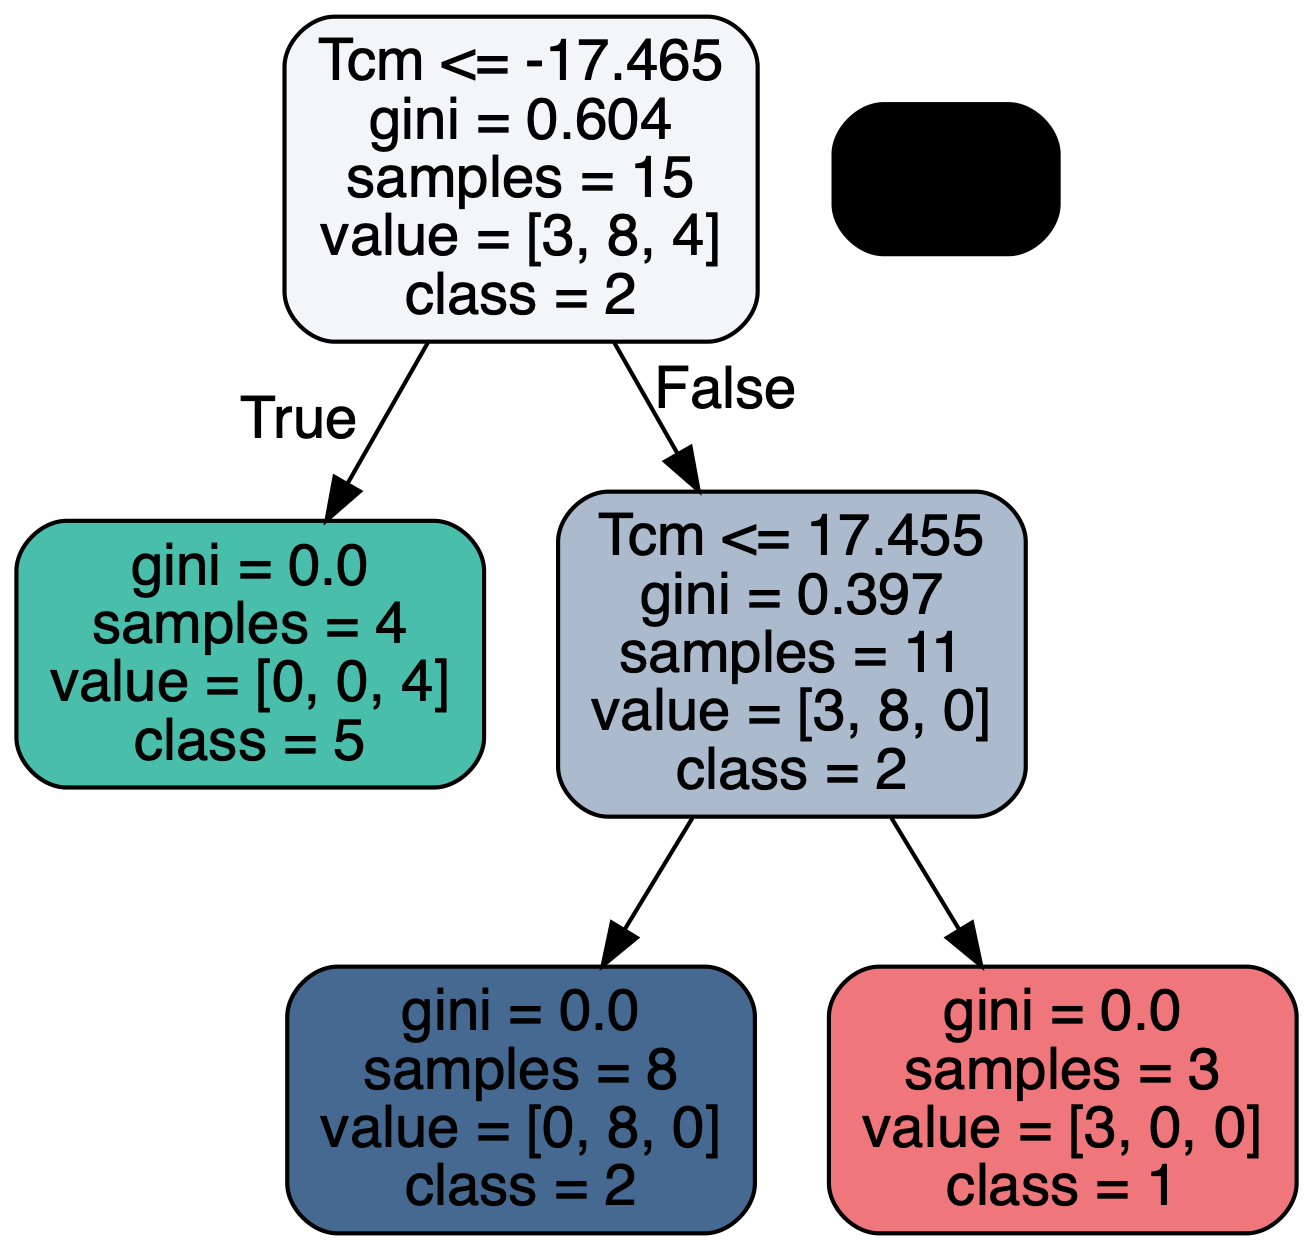

In [42]:
dot_data = StringIO()
export_graphviz(
            model_tri_mini,
            out_file =  dot_data,
            feature_names = ['Twm', 'Tcm', 'Ptot'],
            class_names = ['1','2','5'],
            filled = True,
            rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
nodes = graph.get_node_list()

for node in nodes:
    if node.get_label():
        values = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
        values = [255 * v / sum(values) for v in values]
            
        if np.argmax(values) == 0:
            alpha = int(values[0]-values[1]-values[2])
            alpha = '{:02x}'.format(alpha) #turn into hexadecimal
            color = '#ef767a'+str(alpha)
            
        elif np.argmax(values) == 1:
            alpha = int(values[1]-values[0]-values[2])
            alpha = '{:02x}'.format(alpha)
            color = '#45 69 90'+str(alpha)
            
        else:
            alpha = int(values[2]-values[0]-values[1])
            alpha = '{:02x}'.format(alpha)
            color = '#49beaa'+str(alpha)
            
        node.set_fillcolor(color)

graph.set_dpi('300')

Image(graph.create_png())


Classroom exercises ideas:

Use the bigger data set with five classes and try to reach higher test scores (or similar test scores, but without overfitting), for example by using a different algorithm like Random Forests or XGBoost;

Use the bigger data set with five classes and plot the predicted classes in a map (this involves transforming the array of predictions back into an image), then compare it to the original KG map used above (kc_1984_2013.tif).